# Attribute

**Direct Reference** PINN Repository from Jay Roxis

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Additional Dervative work**: Ben Moseley, PINNs: an introductory crash course

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

# Libraries and Dependencies

In [2]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import warnings
import time
from scipy import signal
from scipy import linalg

warnings.filterwarnings('ignore')

**Check device availability**

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Class for generating dense deep network architecture

In [57]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

### Physics Informed Neural Network Class

In [58]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, t_data, t_physics, X, layers, F):
        
        # Forcing function required to resolve residual
        self.Fdata = torch.tensor(F).float().to(device)
        self.Fdata = torch.reshape(self.Fdata, (len(F),1))

        # data
        self.X = torch.tensor(X, requires_grad=True).float().to(device)
        self.t_data = torch.tensor(t_data, requires_grad=True).float().to(device)
        self.t_physics = torch.tensor(t_physics, requires_grad=True).float().to(device)
        self.xdata = torch.tensor(self.X[:,0:1], requires_grad=True).float().to(device)
        
        # initialize unkown model parameter(s)
        self.c_param = torch.rand(1, requires_grad=True).to(device)
        self.k_param = torch.rand(1, requires_grad=True).to(device)
        self.c_param = torch.nn.Parameter(self.c_param)
        self.k_param = torch.nn.Parameter(self.k_param)
        
        # deep neural network
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('c', self.c_param)
        self.dnn.register_parameter('k', self.k_param)

        # Define coefficients to tune loss component weights
        self.res_scale = 0.0001
        self.data_scale = 1.0

        # store separate losses for visualization (per epoch)
        self.losses = []
        self.datalosses = []
        self.residlosses = []
        self.lossesLBFGS = []
        self.residlossesLBFGS = []
        self.datalossesLBFGS = []
        self.cees = [] #track progress of 'c'
        self.kays = [] #track progress of 'k'


         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = 1e-3)
        self.iter = 0

     #force parameters to be in a range
    @property
    def c(self):
        return 30*abs(self.c_param)

    @property
    def k(self):
        return 30*abs(self.k_param)


    def net_x(self, t):  
        x = self.dnn(t)
        return x
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """       
        c = self.c
        k = self.k
        xnet = self.net_x(t)

        xnet_t = torch.autograd.grad(
            xnet, t, 
            grad_outputs=torch.ones_like(xnet),
            create_graph=True,
        )[0]
        xnet_tt = torch.autograd.grad(
            xnet_t, t, 
            grad_outputs=torch.ones_like(xnet_t),
            create_graph=True,
        )[0]

        f = 1.0*xnet_tt + c*xnet_t + k*xnet # - self.Fdata (assumed to be zero usually) 
        return f
    
    def loss_func(self):         
        x_pred = self.net_x(self.t_data)
        f_pred = self.net_f(self.xdata, self.t_physics)
        loss_data =  torch.mean((self.xdata - x_pred) ** 2)
        loss_resid = torch.mean(f_pred ** 2)
        loss = self.res_scale*loss_resid + self.data_scale*loss_data

        self.optimizer.zero_grad()
        loss.backward()
        self.cees.append(self.c.item())
        self.kays.append(self.k.item())

        self.iter += 1
        if self.iter % 100 == 0:
            self.lossesLBFGS.append(loss.item())
            self.residlossesLBFGS.append(self.res_scale*loss_resid.item())
            self.datalossesLBFGS.append(self.data_scale*loss_data.item())
            print(
                'Loss: %e, c: %.3e,  k: %.3f' % 
                (
                    loss.item(), 
                    self.c.item(),
                    self.k.item()
                )
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter+1):
            x_pred = self.net_x(self.t_data)
            f_pred = self.net_f(self.xdata, self.t_physics)
            loss_data = torch.mean((self.xdata - x_pred) ** 2)
            loss_resid = torch.mean(f_pred ** 2)
            loss = self.res_scale*loss_resid + self.data_scale*loss_data

            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            self.cees.append(self.c.item())
            self.kays.append(self.k.item())

            if epoch % 100 == 0:
                self.losses.append(loss.item())
                self.residlosses.append(self.res_scale*loss_resid.item())
                self.datalosses.append(self.data_scale*loss_data.item())
                print(
                    'It: %d, Loss: %.3e, c: %.3e, k: %.3f' % 
                    (
                        epoch, 
                        loss.item(),
                        self.c.item(),
                        self.k.item()
                    )
                )
                
        # Backward and optimize
        #self.optimizer.step(self.loss_func)
    
    def predict(self, t):
        self.dnn.eval()
        #net_x is 'predicted' based off of what is given
        x = self.net_x(t)
        #net_f is always performed under the training scheme
        f = self.net_f(self.xdata, self.t_physics)
        x = x.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return x, f

### Statespace Function

In [3]:
#Generate a SDOF MSDS using a statespace function
def statespacegenerator(m,c,k,T,dt,x0):
    #System input force in Newtons
    F_train = np.zeros((int(T/dt)))
    j = 0
    for i in range (0,int(T/dt)):
        F_train[[i]] = 0#*(-0.5*np.exp(j*0.05)*np.sin(4*j)+2*np.exp(j*0.05)*np.cos(4*j))
        j = j+dt

    #State space model for a SDOF system
    #discretize the time steps 
    tdiscrete = np.arange(0,T,dt)

    A = [[0,1], [-k/m, -c/m]]
    B = [[0],[1/m]]
    C = [[1,0]]
    SDOFsys = signal.StateSpace(A,B,C,0)
    [timetrace, y, x] = signal.lsim(SDOFsys, F_train, tdiscrete, x0)

    return timetrace, y, x, F_train

### Synthesize Data

In [4]:
layers = [1, 32, 32, 32, 1]
#Generate synthetic data
x0 = np.array([1,0])
timestep = 0.001
m = 1
c = 4
k = 400
timetotal = 1
[t,y,x,F] = statespacegenerator(m,c,k,timetotal,timestep,x0)
#Re-define 'xtrain' as the network input
t_train = np.transpose(t)
t_train = np.reshape(t_train, (len(t),1))
F_train = np.transpose(F)
F_train = np.reshape(F_train, (len(F),1))
state_train = x

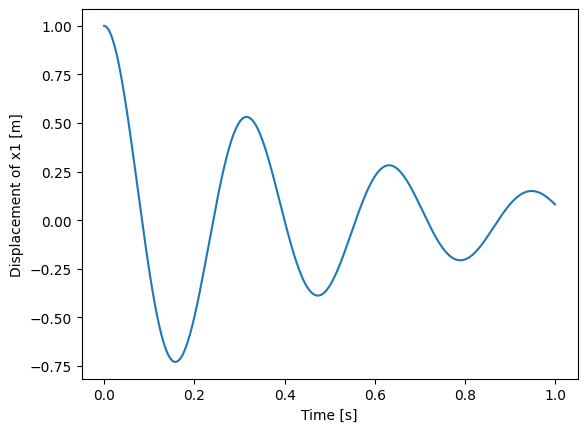

In [5]:
plt.plot(t,x[:,0])
plt.xlabel('Time [s]')
plt.ylabel('Displacement of x1 [m]')
plt.show()

### Sparsify Data

In [61]:
#sparsify time and x outputs
sparse_count = 30
combined_exact_data = np.hstack((t_train, F_train, state_train))
#combined_exact_data = np.hstack((t_train, F_train, state_train))
idxsparse = np.random.choice(range(int(indextrain)), sparse_count, replace = False)
idxsparse = np.sort(idxsparse)
sparse_exact = combined_exact_data[idxsparse, :]
t_train_sparse = sparse_exact[:,0:1]
F_train_sparse = sparse_exact[:,1:2]
state_train_sparse = sparse_exact[:,2:4]
y_sparse = state_train_sparse[:,0:1]


#noisy option
noise = np.random.normal(0,1, state_train_sparse.shape)
state_train_sparse_noise = state_train_sparse + (0.1)*noise#*state_train_sparse
y_sparse_noise = state_train_sparse_noise[:,0:1]


In [62]:
#Train with sparse data
# line up physics mesh to align with baseline
t_phys = np.linspace(0,1,1000)
t_phys = np.transpose(t_phys)
t_phys = np.reshape(t_phys, (len(t_phys),1))
model = PhysicsInformedNN(t_train_sparse, t_phys, state_train_sparse_noise, layers, F_train)

#check number of params
total_params = sum(p.numel() for p in model.dnn.parameters())
print(total_params)

model.train(35000)

2211
It: 0, Loss: 2.807e-01, c: 2.086e+01, k: 27.843
It: 100, Loss: 2.275e-01, c: 2.275e+01, k: 25.113
It: 200, Loss: 2.128e-01, c: 1.768e+01, k: 21.750
It: 300, Loss: 1.180e-01, c: 9.557e+00, k: 21.525
It: 400, Loss: 1.019e-01, c: 1.030e+01, k: 26.364
It: 500, Loss: 9.254e-02, c: 1.231e+01, k: 30.309
It: 600, Loss: 8.501e-02, c: 1.436e+01, k: 33.674
It: 700, Loss: 8.055e-02, c: 1.610e+01, k: 36.642
It: 800, Loss: 7.872e-02, c: 1.730e+01, k: 39.390
It: 900, Loss: 7.641e-02, c: 1.810e+01, k: 42.029
It: 1000, Loss: 7.516e-02, c: 1.867e+01, k: 44.614
It: 1100, Loss: 7.459e-02, c: 1.909e+01, k: 47.172
It: 1200, Loss: 7.319e-02, c: 1.942e+01, k: 49.724
It: 1300, Loss: 7.235e-02, c: 1.967e+01, k: 52.261
It: 1400, Loss: 7.158e-02, c: 1.988e+01, k: 54.798
It: 1500, Loss: 7.084e-02, c: 2.003e+01, k: 57.358
It: 1600, Loss: 7.047e-02, c: 2.017e+01, k: 59.905
It: 1700, Loss: 6.947e-02, c: 2.027e+01, k: 62.476
It: 1800, Loss: 6.881e-02, c: 2.036e+01, k: 65.069
It: 1900, Loss: 6.819e-02, c: 2.041e+0

### Sparse Data visualizations

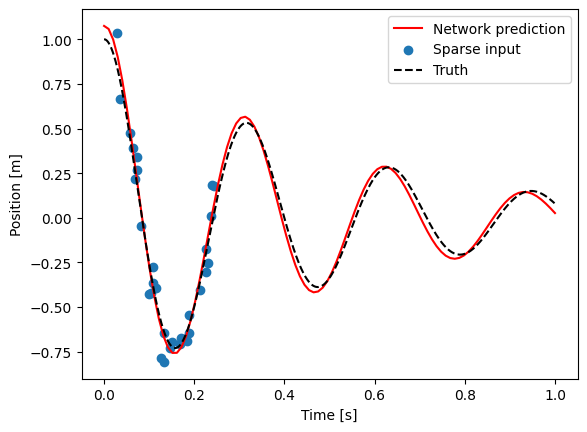

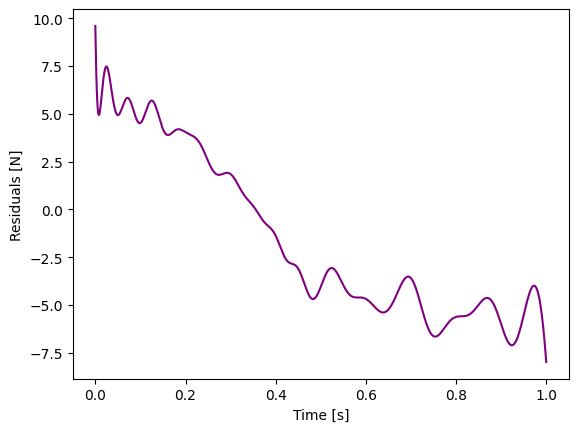

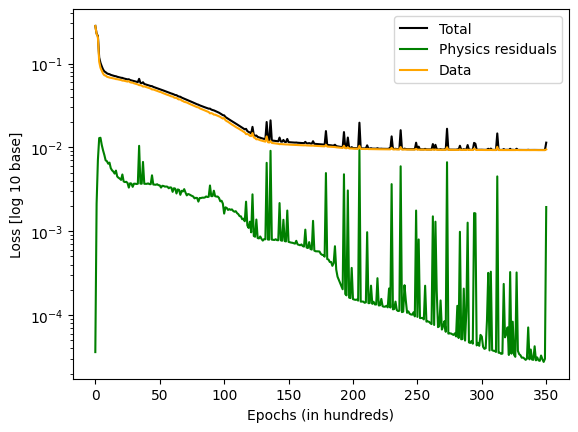

Adam final losses
Loss:  1.1380e-02, Residuals loss: 1.9417e-03, Data loss: 9.4382e-03
Estimated c value
4.089484214782715
Estimated k value
414.9000549316406


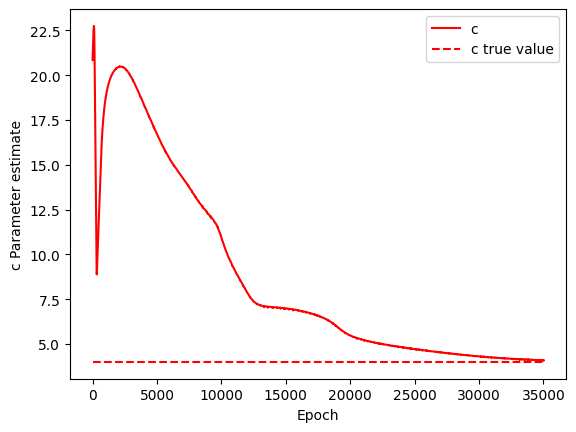

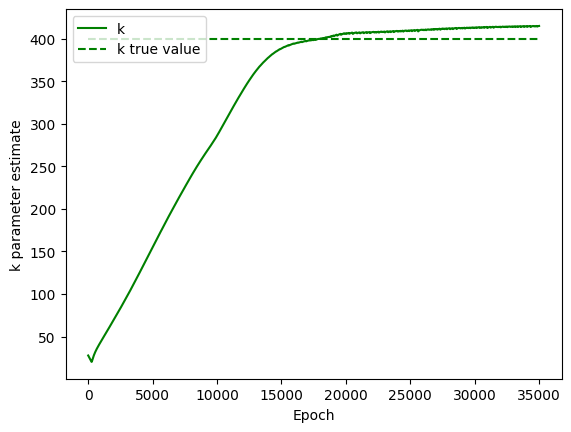

In [65]:
#print noisy ICs
#print(x0noisy)

#plot true result
t_inter = np.linspace(0,1,100)
t_inter = np.transpose(t_inter)
t_inter = np.reshape(t_inter, (len(t_inter),1))
ttensor = torch.tensor(t_inter).float().to(device)
[ynet, fnet] = model.predict(ttensor)
plt.plot(t_inter, ynet, color = 'red', label = 'Network prediction')
plt.scatter(t_train_sparse, y_sparse_noise, label = 'Sparse input')
plt.plot(t,y, 'k--', label = 'Truth' )
plt.legend()
#plt.title('Network recreation of training dataset')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.show()

#Plot residuals
plt.plot(t_phys, fnet, color = 'purple')
#plt.title('Physics Residuals from Trained Network')
plt.xlabel('Time [s]')
plt.ylabel('Residuals [N]')
plt.show()

#Plot Noisy Loss (ADAM)
plt.plot(model.losses[0:],color = 'black', label = "Total")
plt.plot(model.residlosses[0:],color = 'green', label = "Physics residuals")
plt.plot(model.datalosses[0:],color = 'orange', label = "Data")
plt.legend()
plt.yscale("log")
#plt.title("Loss trends under ADAM optimization")
plt.xlabel('Epochs (in hundreds)')
plt.ylabel('Loss [log 10 base]')
plt.show()
# Print final loss components
print('Adam final losses')
print('Loss:  %.4e, Residuals loss: %.4e, Data loss: %.4e' % 
        (
            model.losses[-1],
            model.residlosses[-1],
            model.datalosses[-1]
        )
    )

print('Estimated c value')
print(model.c.item())

print('Estimated k value')
print(model.k.item())

# plot the learned c against the true c
plt.plot(model.cees, label = 'c', color="red")
plt.hlines(4, 0, len(model.cees), label="c true value", color="red", linestyle = 'dashed')
plt.legend()
#plt.title('Learned damping coefficient over training steps')
plt.xlabel('Epoch')
plt.ylabel('c Parameter estimate')
plt.show()

# learned k against true k
plt.plot(model.kays, label = 'k', color="green")
plt.hlines(400, 0, len(model.kays), label="k true value", color="green", linestyle = 'dashed')
plt.legend()
#plt.title('Learned damping coefficient over training steps')
plt.xlabel('Epoch')
plt.ylabel('k parameter estimate')
plt.show()

